In [1]:
!pip install opensmile gdown --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 13.7 MB/s eta 0:00:00


### Accessing Dataset

In [2]:
import os
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa
import librosa.display
from IPython.display import Audio, display
import pandas as pd
import numpy as np
import soundfile as sf
import tempfile
import opensmile
import pandas as pd


!gdown 1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS

tarball_filename = "ADReSSo21-diagnosis-train.tar"

# extract all contents from the tarball into the current working directory
with tarfile.open(tarball_filename, 'r:*') as tar:
    tar.extractall(path="./")

# remove the tarball after extraction
os.remove(tarball_filename)

Downloading...
From (original): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS
From (redirected): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS&confirm=t&uuid=aafc599f-40dc-4626-9ef7-6edfacdbb8f4
To: /content/ADReSSo21-diagnosis-train.tar
100% 1.75G/1.75G [00:29<00:00, 60.1MB/s]


### Helper Functions

In [9]:
# define the base dataset directory and build related paths
dataset_dir = Path('ADReSSo21/diagnosis/train')
paths = {
    'audio': dataset_dir / 'audio',
    'audio_ad': dataset_dir / 'audio' / 'ad',
    'audio_cn': dataset_dir / 'audio' / 'cn',
    'segmentation': dataset_dir / 'segmentation',
    'segmentation_ad': dataset_dir / 'segmentation' / 'ad',
    'segmentation_cn': dataset_dir / 'segmentation' / 'cn'
}

def count_files(directory):
    """return the number of files in the specified directory."""
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

def plot_waveform_data(waveform, sr, title="Waveform"):
    """plot the given waveform with its sampling rate."""
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(waveform, sr=sr)
    plt.title(title)
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.show()

def plot_waveform(file_path=None, folder=paths['audio_ad']):
    """
    load an audio file (default: first .wav in folder) and plot its waveform.
    """
    if file_path is None:
        wav_files = list(folder.glob("*.wav"))
        if not wav_files:
            print(f"no .wav files found in {folder}")
            return
        file_path = wav_files[0]
    else:
        file_path = Path(file_path)

    waveform, sr = librosa.load(str(file_path), sr=None)
    print("original waveform shape:", waveform.shape)
    print("sampling rate:", sr)
    print("duration (seconds):", len(waveform) / sr, "\n")

def load_audio_file(file_path: Path):
    """load and return the audio waveform and sample rate using soundfile."""
    return sf.read(file_path)

def load_segmentation(seg_file: Path):
    """load and return the segmentation csv as a dataframe."""
    return pd.read_csv(seg_file)

def extract_patient_segments(audio: np.ndarray, sr: int, seg_df: pd.DataFrame, speaker: str = "PAR"):
    """
    extract patient segments (where speaker==speaker) from the audio.
    returns:
      - patient_mask: array with patient segments (nan elsewhere).
      - concatenated: patient segments concatenated.
      - segments: list of (begin, end) sample index tuples.
    """
    patient_df = seg_df[seg_df['speaker'] == speaker]
    patient_mask = np.full_like(audio, np.nan)
    segments_list = []
    segments = []

    for _, row in patient_df.iterrows():
        begin_sample = int(float(row['begin']) * sr / 1000)
        end_sample = int(float(row['end']) * sr / 1000)
        patient_mask[begin_sample:end_sample] = audio[begin_sample:end_sample]
        segments_list.append(audio[begin_sample:end_sample])
        segments.append((begin_sample, end_sample))

    concatenated = np.concatenate(segments_list) if segments_list else np.array([])
    return patient_mask, concatenated, segments

def plot_overlay_waveform(audio: np.ndarray, sr: int, patient_mask: np.ndarray,
                          orig_color: str = "#0000FF", patient_color: str = "#00FF00"):
    """plot the original waveform with patient-only segments overlay."""
    time_axis = np.linspace(0, len(audio) / sr, num=len(audio))
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, color=orig_color, label="original")
    plt.plot(time_axis, patient_mask, color=patient_color, label="patient-only")
    plt.title("original audio with patient speech highlighted")
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.legend()
    plt.show()

def process_audio(audio_file: Path, seg_file: Path, plot: bool = False):
    """
    load audio and segmentation files, extract patient segments,
    optionally plot the overlay, and return processed data.
    returns:
      audio, sr, patient_mask, concatenated (patient-only audio), segments
    """
    audio, sr = load_audio_file(audio_file)
    seg_df = load_segmentation(seg_file)
    patient_mask, concatenated, segments = extract_patient_segments(audio, sr, seg_df)
    if plot:
        plot_overlay_waveform(audio, sr, patient_mask)
    return audio, sr, patient_mask, concatenated, segments

def get_egemaps_features(patient_audio: np.ndarray, sr: int, audio_identifier: str) -> pd.DataFrame:
    """
    write the patient audio to a temporary wav file, extract the egemaps feature vector,
    and return a dataframe containing the features along with the audio identifier.

    parameters:
      patient_audio: numpy array with patient-only (concatenated) audio.
      sr: sampling rate of the audio.
      audio_identifier: a string identifier for the audio file.

    returns:
      dataframe with the extracted feature vector and an 'audio_file' column.
    """
    # write patient audio to a temporary wav file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
        temp_filename = tmp_file.name
    sf.write(temp_filename, patient_audio, sr)

    # initialize the opensmile smile object with egemaps settings
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv01a,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    # extract egemaps features from the temporary wav file
    features_df = smile.process_file(temp_filename)

    # add audio identifier to the dataframe
    features_df['audio_file'] = audio_identifier

    # reorder columns so that 'audio_file' is first
    cols = features_df.columns.tolist()
    cols = ['audio_file'] + [col for col in cols if col != 'audio_file']
    features_df = features_df[cols]

    # print the shape of the feature vector
    print(f"shape of the egemaps feature vector: {features_df.shape}")

    return features_df

### Data Analysis

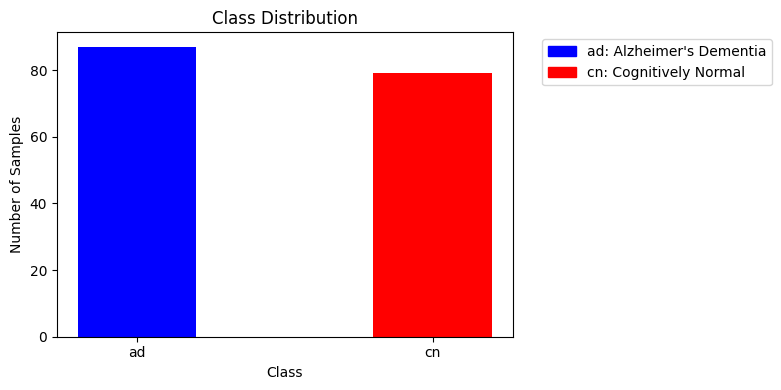

In [4]:
# count files in each audio directory
ad_count = count_files(str(paths['audio_ad']))
cn_count = count_files(str(paths['audio_cn']))

# prepare data for plotting
classes = ['ad', 'cn']
counts = [ad_count, cn_count]
colors = ['blue', 'red']

# create bar chart
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(classes, counts, color=colors, width=bar_width)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')

# create legend
legend_handles = [
    mpatches.Patch(color='blue', label="ad: Alzheimer's Dementia"),
    mpatches.Patch(color='red', label="cn: Cognitively Normal")
]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


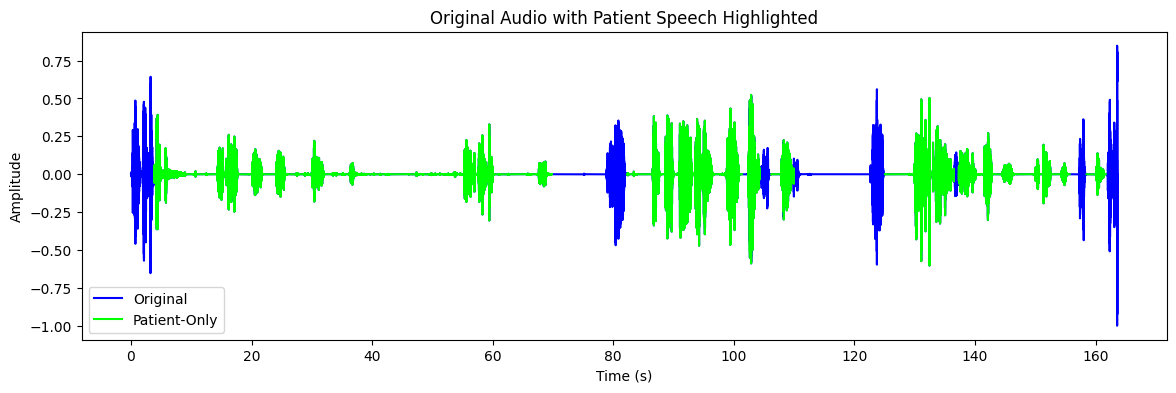

In [5]:
# retrieve the first .wav file from the 'audio_ad' directory
first_audio_file = next(paths['audio_ad'].glob("*.wav"), None)
if first_audio_file is None:
    raise FileNotFoundError("No audio file found in the specified directory.")

# construct the corresponding segmentation CSV file path
audio_basename = first_audio_file.stem
seg_file = paths['segmentation_ad'] / f"{audio_basename}.csv"

# process the audio file with overlay plot enabled
audio, sr, patient_mask, concatenated, segments = process_audio(first_audio_file, seg_file, plot=True)


### Processing Audio

- parallelize the audio processing, probably using joblib

In [8]:
egemaps_features = get_egemaps_features(concatenated, sr, str(audio_basename))

# Ssve the features along with the file name as the first column to a CSV in the current working directory
csv_output_filename = "egemaps_features.csv"
egemaps_features.to_csv(csv_output_filename, index=False)

print(f"eGeMAPS features saved to {csv_output_filename}")

/usr/local/lib/python3.11/dist-packages/opensmile/core/smile.py:252: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(


Shape of the eGeMAPS feature vector: (1, 89)
eGeMAPS features saved to egemaps_features.csv


### Feature Extraction

- basic eGeMAPS feature set
- paralleiz using joblib
